# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
#plt.style.use('seaborn')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [3]:
def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    data_complete = []
    for student in sorted(os.listdir(data_dir)):
        student_path = os.path.join(data_dir, student)
        if not os.path.isdir(student_path):
            continue
        subject_id = student
        for session in ['Midterm 1', 'Midterm 2', 'Final']:
            session_path = os.path.join(student_path, session)
            #Loading in HR data
            hr_path = os.path.join(session_path, 'HR.csv')
            hr_raw = pd.read_csv(hr_path, header=None)
            hr_start = float(hr_raw.iloc[0, 0]) #starting timestamp, row 1
            hr_rate = float(hr_raw.iloc[1, 0]) #sampling frequency, row 2
            hr_data = hr_raw.iloc[2:, 0].astype(float).reset_index(drop=True)
            hr_times = pd.to_datetime(np.arange(len(hr_data)) / hr_rate + hr_start, unit='s', utc=True) #converting to datetime
            hr_df = pd.DataFrame({'timestamp': hr_times, 'heart_rate': hr_data}).set_index('timestamp')
            hr_df = hr_df.resample('1s').mean()

            #Loading in EDA data
            eda_path = os.path.join(session_path, 'EDA.csv')
            eda_raw = pd.read_csv(eda_path, header=None)
            eda_start = float(eda_raw.iloc[0, 0]) #starting timestamp, row 1
            eda_rate = float(eda_raw.iloc[1, 0]) #sampling frequency, row 2
            eda_data = eda_raw.iloc[2:, 0].astype(float).reset_index(drop=True)
            eda_times = pd.to_datetime(np.arange(len(eda_data)) / eda_rate + eda_start, unit='s', utc=True)
            eda_df = pd.DataFrame({'timestamp': eda_times, 'eda': eda_data}).set_index('timestamp')
            eda_df = eda_df.resample('1s').mean()

            #Loading in TEMP data
            temp_path = os.path.join(session_path, 'TEMP.csv')
            temp_raw = pd.read_csv(temp_path, header=None)
            temp_start = float(temp_raw.iloc[0, 0])
            temp_rate = float(temp_raw.iloc[1, 0])
            temp_data = temp_raw.iloc[2:, 0].astype(float).reset_index(drop=True)
            temp_times = pd.to_datetime(np.arange(len(temp_data)) / temp_rate + temp_start, unit='s', utc=True)
            temp_df = pd.DataFrame({'timestamp': temp_times, 'temperature': temp_data}).set_index('timestamp')
            temp_df = temp_df.resample('1s').mean()

            df = pd.concat([hr_df, eda_df, temp_df], axis=1)
            df['subject_id'] = subject_id
            df['session'] = session
            df.reset_index(inplace=True)
            data_complete.append(df)
    return pd.concat(data_complete, ignore_index = True)



In [4]:
load_data(data_dir='data/raw')

,timestamp,heart_rate,eda,temperature,subject_id,session
0,2018-10-13 12:56:06+00:00,NaN,0.010892,22.51,S1,Midterm 1
1,2018-10-13 12:56:07+00:00,NaN,0.023065,22.51,S1,Midterm 1
2,2018-10-13 12:56:08+00:00,NaN,0.023386,22.51,S1,Midterm 1
3,2018-10-13 12:56:09+00:00,NaN,0.022424,22.51,S1,Midterm 1
4,2018-10-13 12:56:10+00:00,NaN,0.023386,22.49,S1,Midterm 1
...,...,...,...,...,...,...
443297,2018-12-05 20:25:49+00:00,126.30,0.011212,23.21,S9,Final
443298,2018-12-05 20:25:50+00:00,125.58,0.010892,23.23,S9,Final
443299,2018-12-05 20:25:51+00:00,124.68,0.011532,23.21,S9,Final
443300,2018-12-05 20:25:52+00:00,123.87,0.011852,23.21,S9,Final


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [5]:
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    processed_data = []
    for subject_id, subject_df in data.groupby("subject_id"):
        subject_processed = []
        subject_df['session'] = subject_df['session'].str.strip().str.lower()
        
        for session, session_df in subject_df.groupby("session"):
            df = session_df.copy()
            df.set_index("timestamp", inplace=True)

    # 1. Handle missing values
            cols = ['heart_rate', 'eda', 'temperature']
            for col in cols:
                df[col] = df[col].fillna(df[col].median())

    # 2. Resample to regular intervals - covered in load_data function, df already resampled to 1 Hz

    # 3. Remove outliers (z-score > 3)
    #dropping value if z-score above threshold of 3
            mean_vals = df[cols].mean()
            std_vals = df[cols].std()
            z_scores = (df[cols] - mean_vals) / std_vals
            df = df[(z_scores.abs() < 3.5).all(axis=1)]

            df['subject_id'] = subject_id
            df['session'] = session
            df.reset_index(inplace=True)
            subject_processed.append(df)
            processed_data.append(df)
    # 4. Save processed data to CSV files
        subject_data = pd.concat(subject_processed, ignore_index=True)
        filename = f"{subject_id}_processed.csv"
        file_path = os.path.join(output_dir, filename)
        subject_data.to_csv(file_path, index=False)

    return pd.concat(processed_data, ignore_index=True)


    

In [6]:
data = load_data(data_dir='data/raw')
preprocess_data(data, output_dir='data/processed')

,timestamp,heart_rate,eda,temperature,subject_id,session
0,2018-12-05 16:28:57+00:00,108.28,0.011852,21.89,S1,final
1,2018-12-05 16:28:58+00:00,108.28,0.023064,21.89,S1,final
2,2018-12-05 16:28:59+00:00,108.28,0.023704,21.91,S1,final
3,2018-12-05 16:29:00+00:00,108.28,0.023384,21.91,S1,final
4,2018-12-05 16:29:01+00:00,108.28,0.023704,21.89,S1,final
...,...,...,...,...,...,...
438229,2018-11-10 17:44:42+00:00,159.47,0.015055,22.97,S9,midterm 2
438230,2018-11-10 17:44:43+00:00,158.68,0.014735,22.97,S9,midterm 2
438231,2018-11-10 17:44:44+00:00,157.72,0.014735,22.97,S9,midterm 2
438232,2018-11-10 17:44:45+00:00,156.45,0.014735,31.09,S9,midterm 2


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [7]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Create figure with subplots
    # 2. Plot each physiological signal
    # 3. Add labels and titles
    # 4. Save plot to file

    df = data[(data['subject_id'] == subject_id) & (data['session'] == session)].copy()
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    #HR Plot
    axes[0].plot(data['timestamp'], data['heart_rate'], color='red', label='Heart Rate')
    axes[0].set_ylabel('HR')
    axes[0].grid(True)
    axes[0].legend()
    #EDA Plot
    axes[1].plot(data['timestamp'], data['eda'], color='green', label='EDA')
    axes[1].set_ylabel('EDA')
    axes[1].grid(True)
    axes[1].legend()
    #Temperature Plot
    axes[2].plot(data['timestamp'], data['temperature'], color='blue', label='Temperature')
    axes[2].set_ylabel('Temp')
    axes[2].set_xlabel('Time')
    axes[2].grid(True)
    axes[2].legend()
    # Saving plot to file
    filename = f"{subject_id}_{session}_plot.png".replace(" ", "_").lower()
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath)
    return fig

In [8]:
# Creating plots for all students, saving to plots directory
def generate_all_plots(processed_dir = 'data/processed', output_dir='plots'):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(processed_dir):
        if filename.endswith('_processed.csv'):
            file_path = os.path.join(processed_dir, filename)
            df = pd.read_csv(file_path, parse_dates=['timestamp'])

            subject_id = df['subject_id'].iloc[0]
            for session in df['session'].unique():
                plot_physiological_signals(
                    df,
                    subject_id=subject_id,
                    session=session,
                    output_dir=output_dir
                )

/tmp/ipykernel_24605/679113760.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)


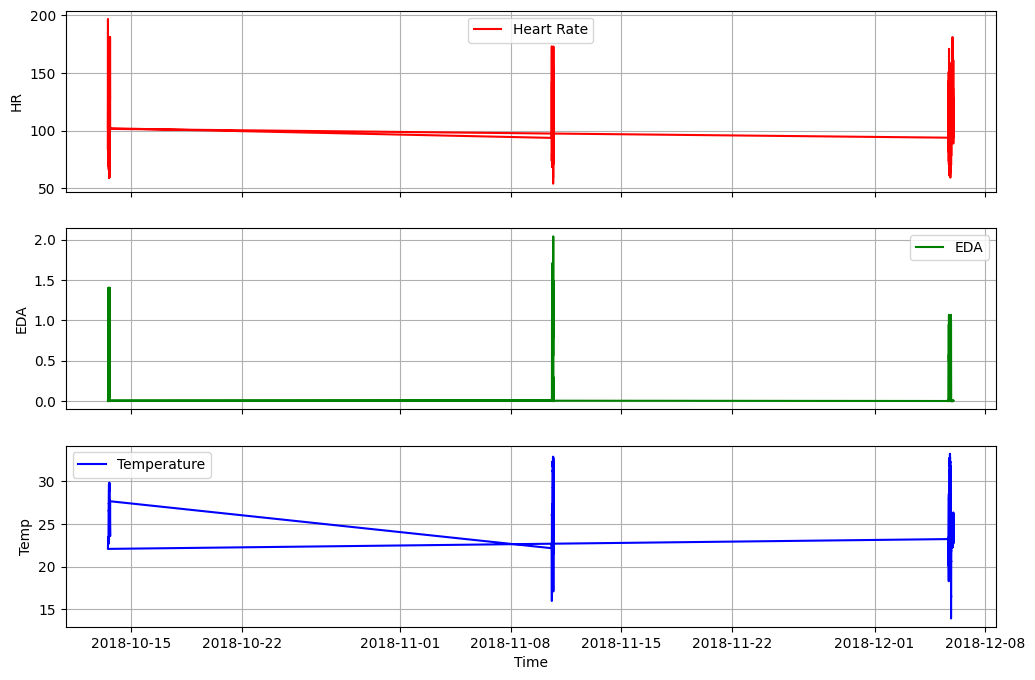

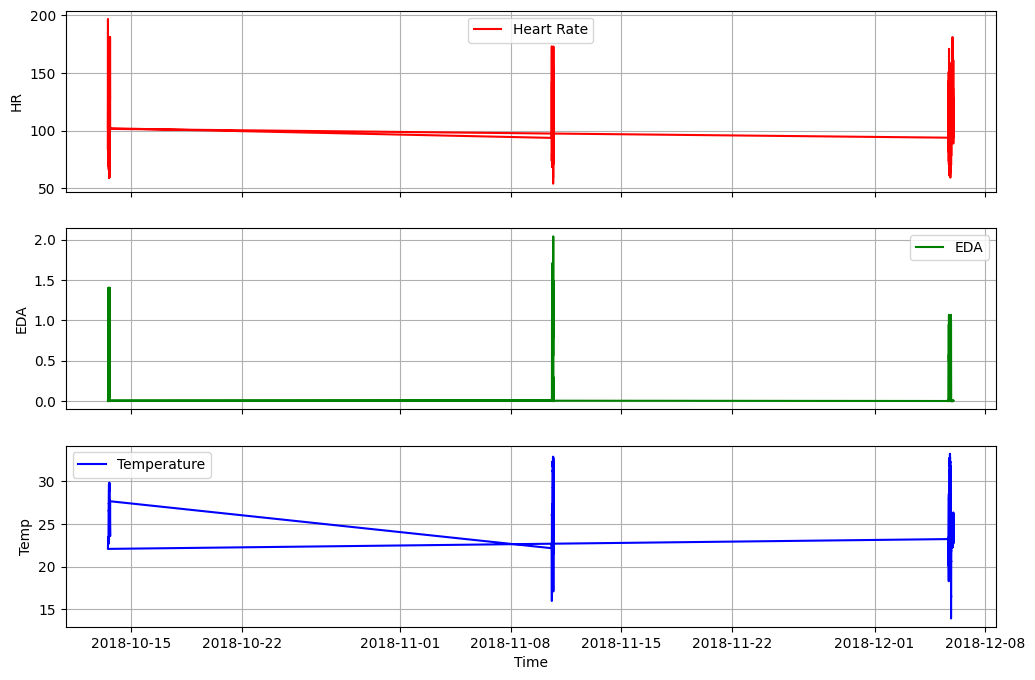

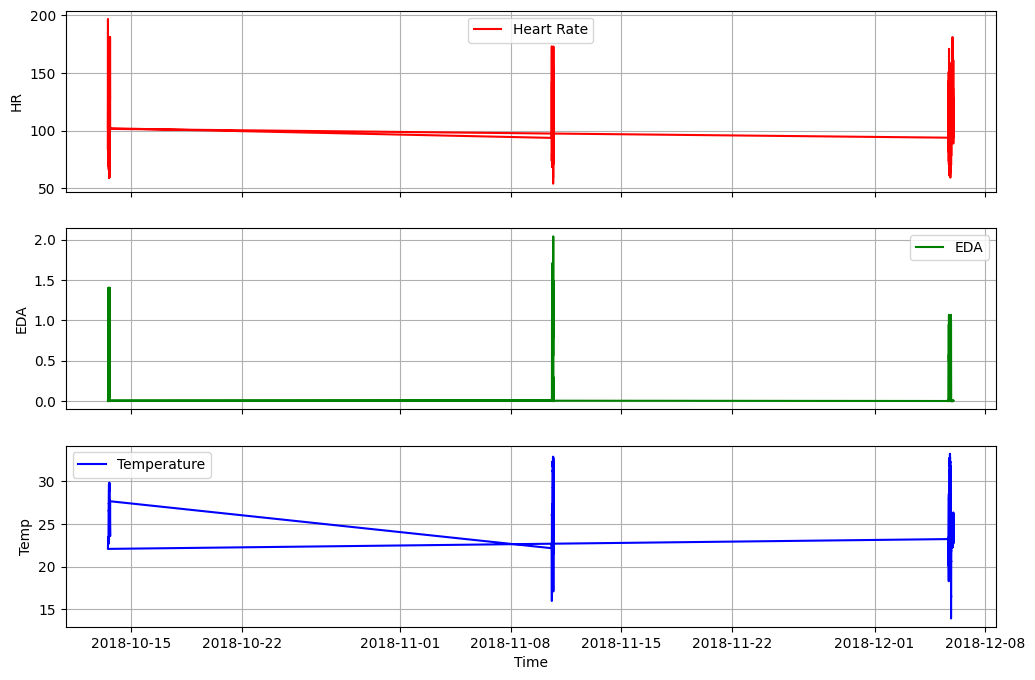

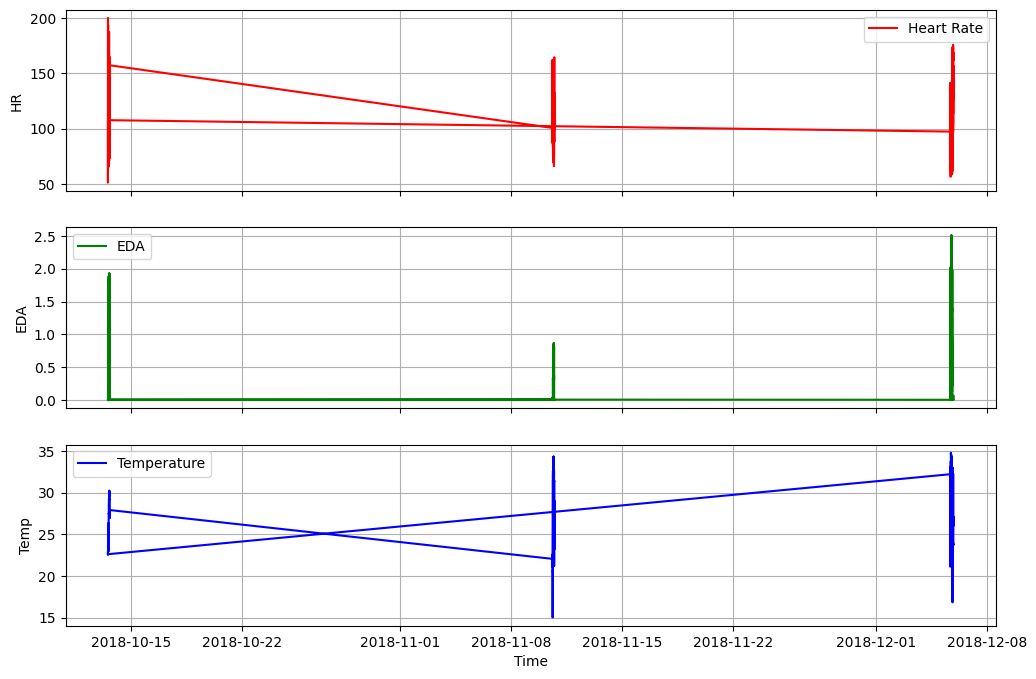

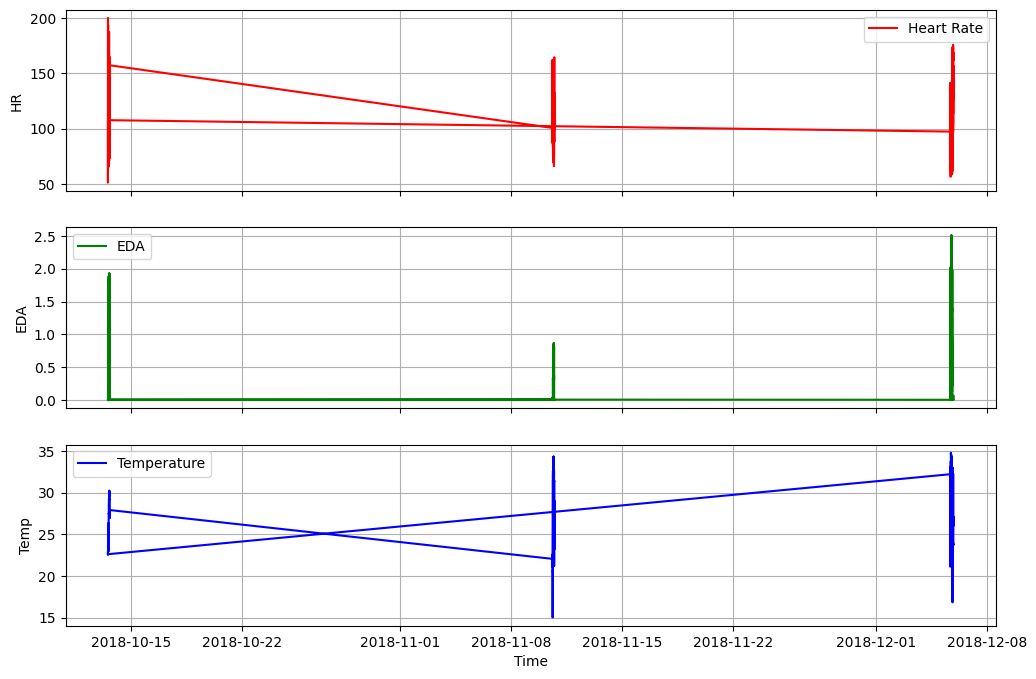

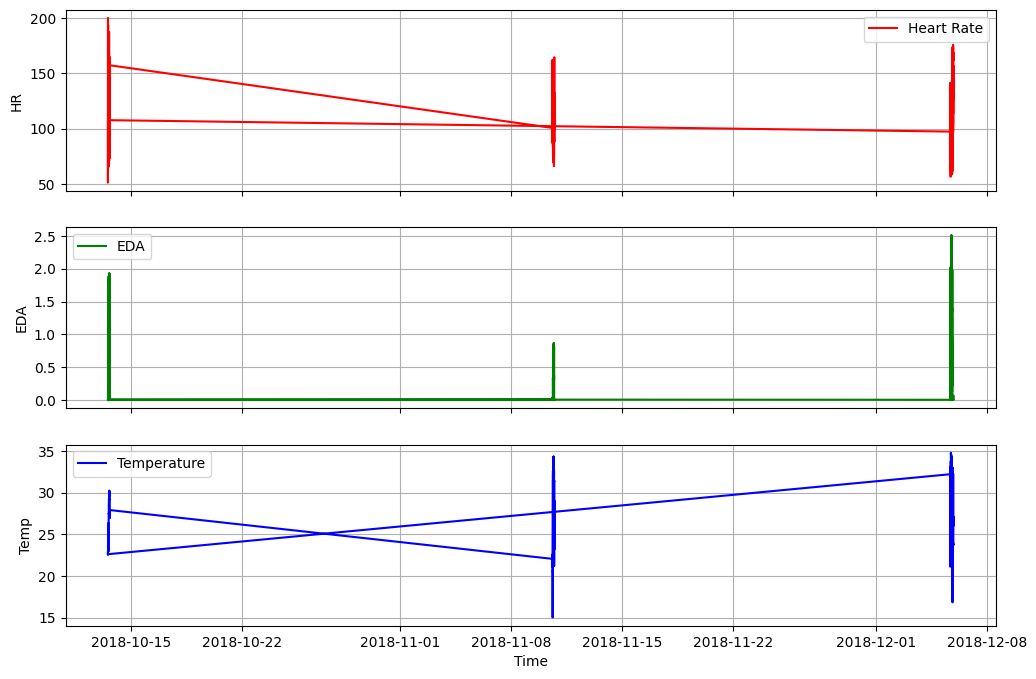

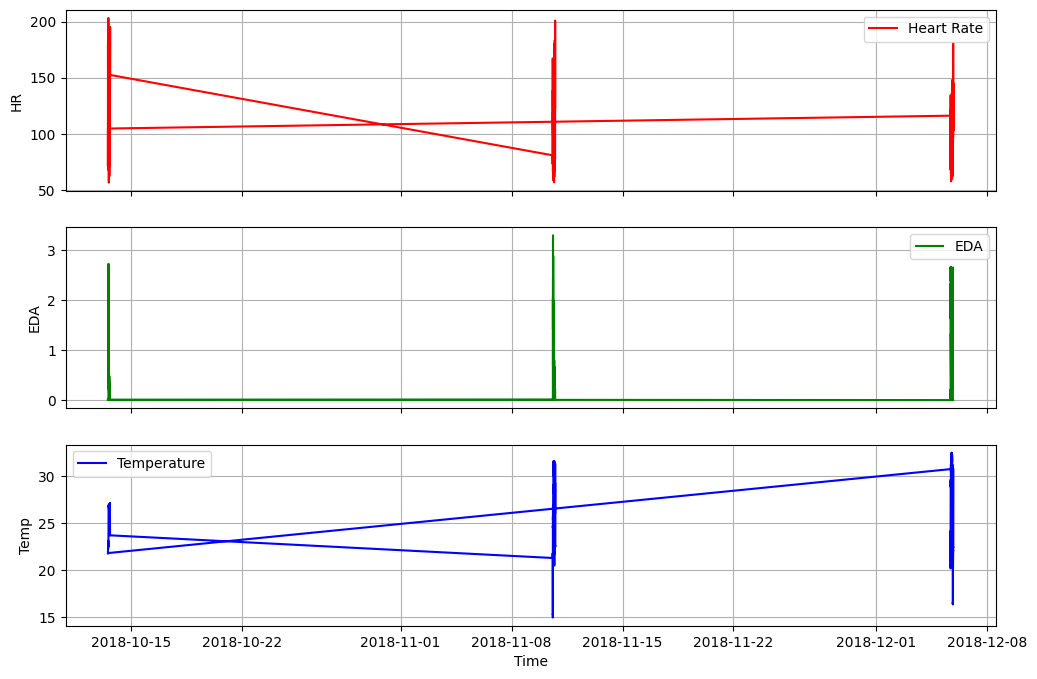

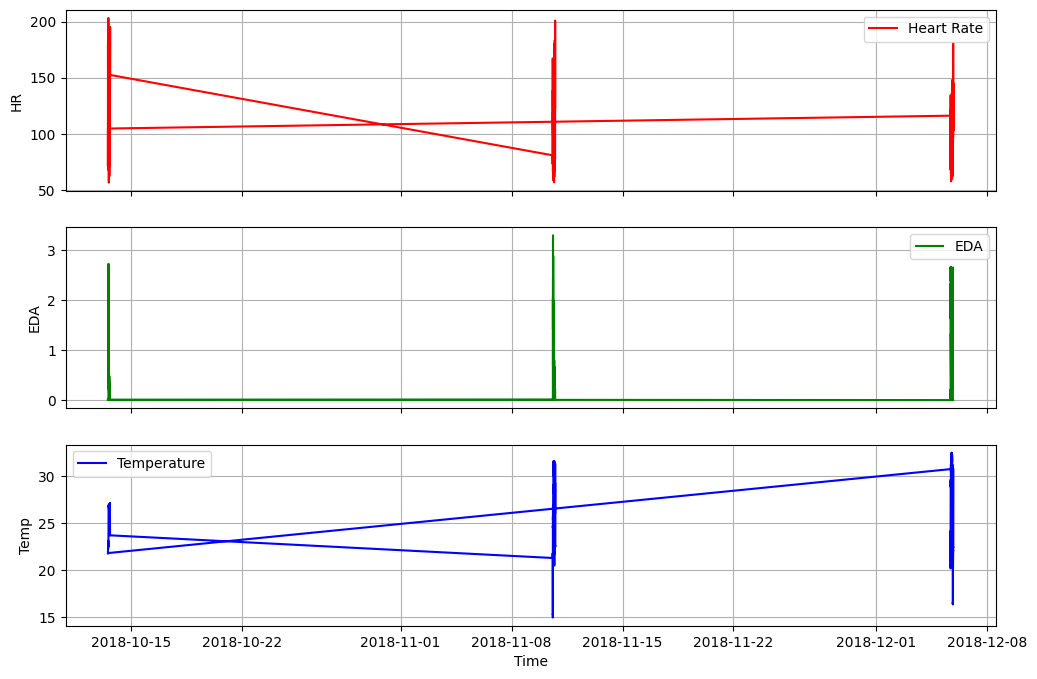

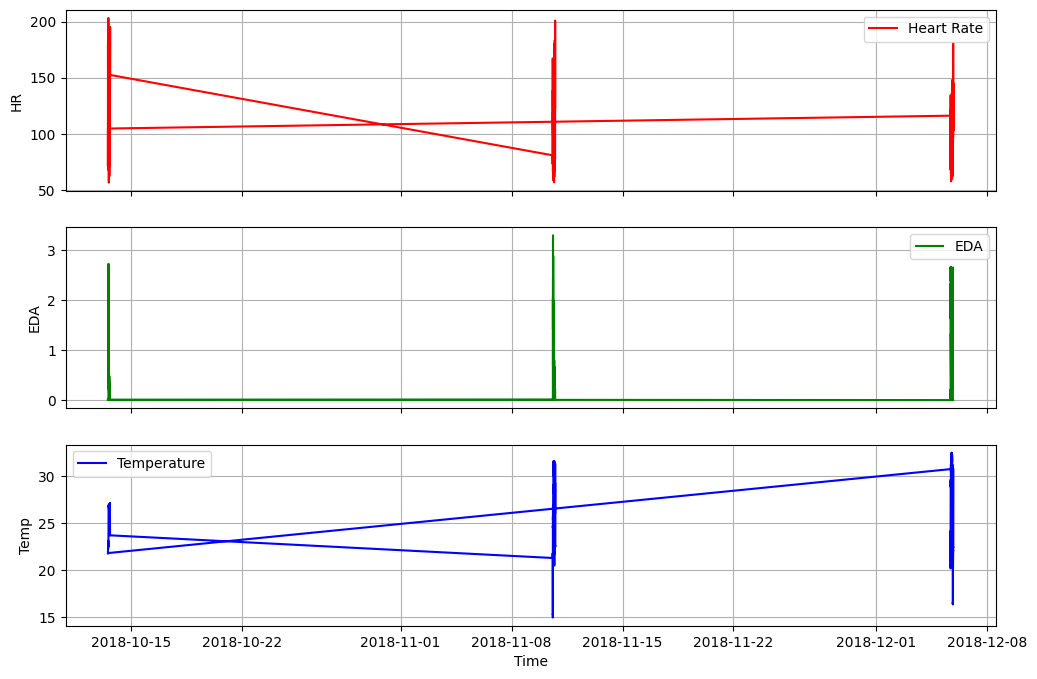

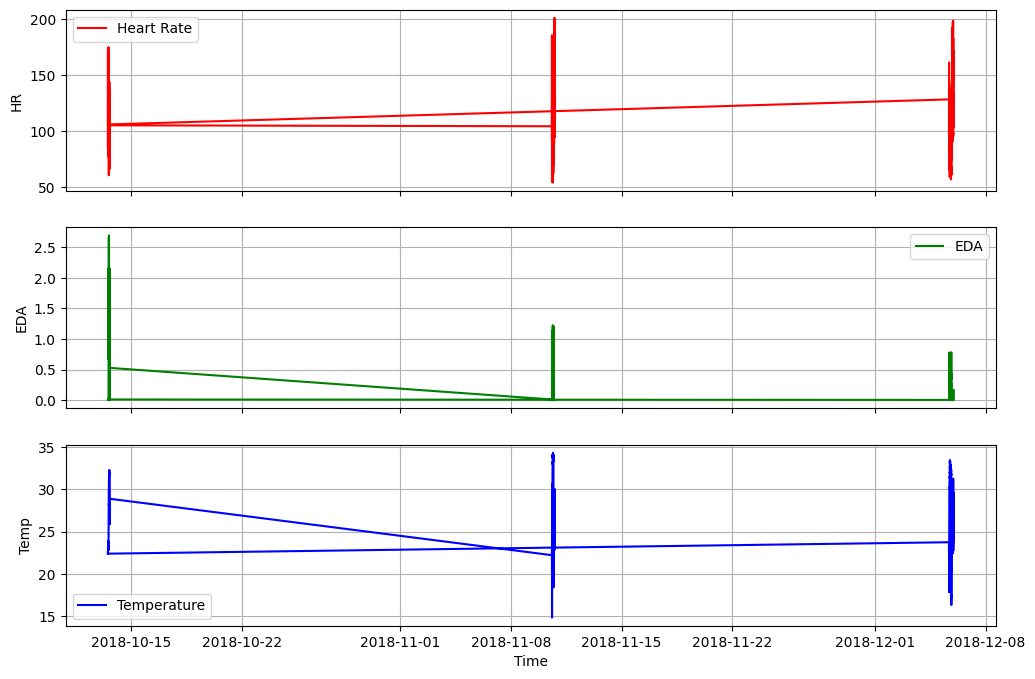

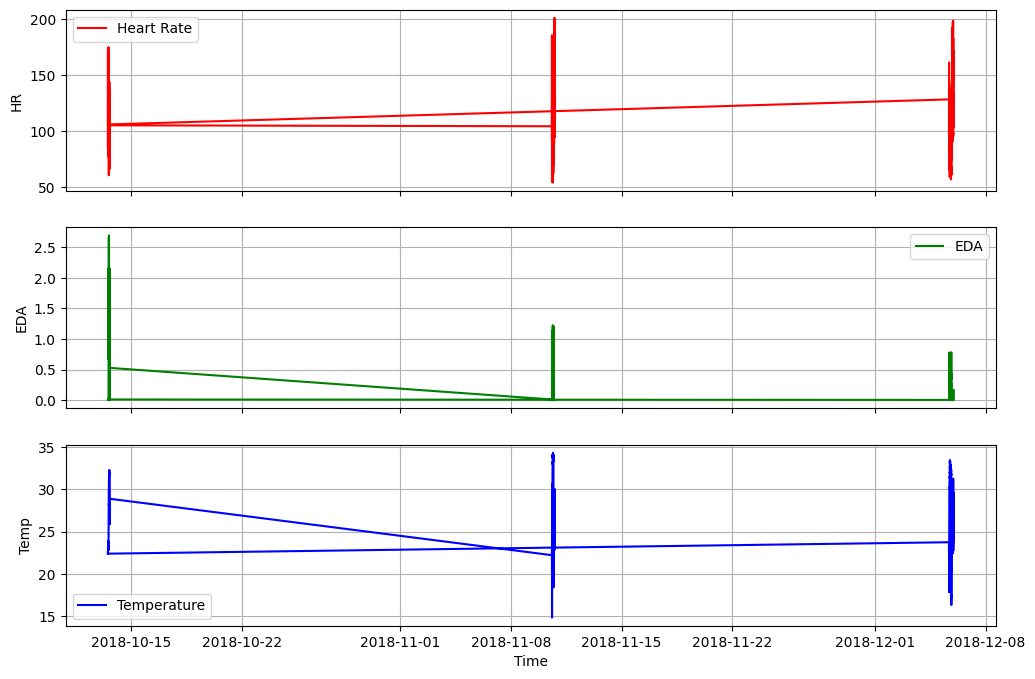

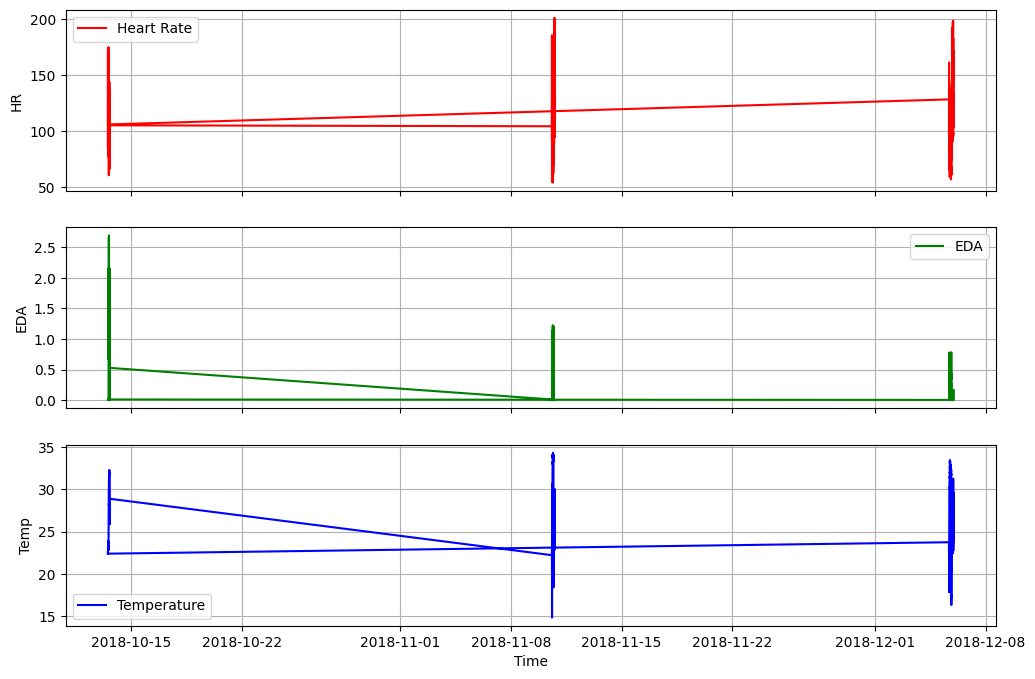

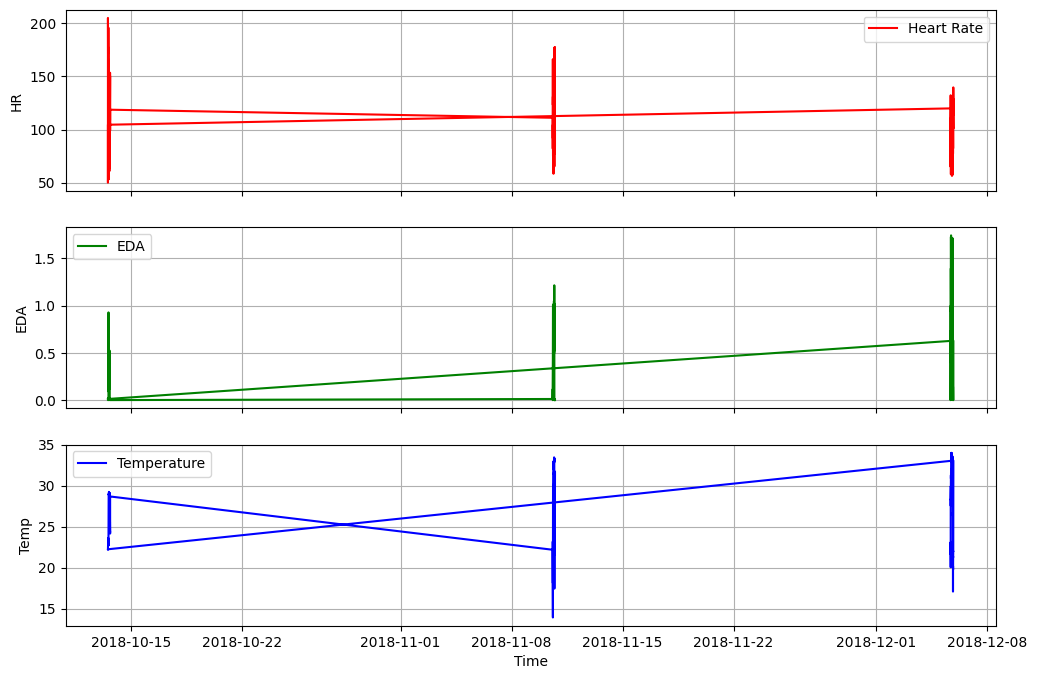

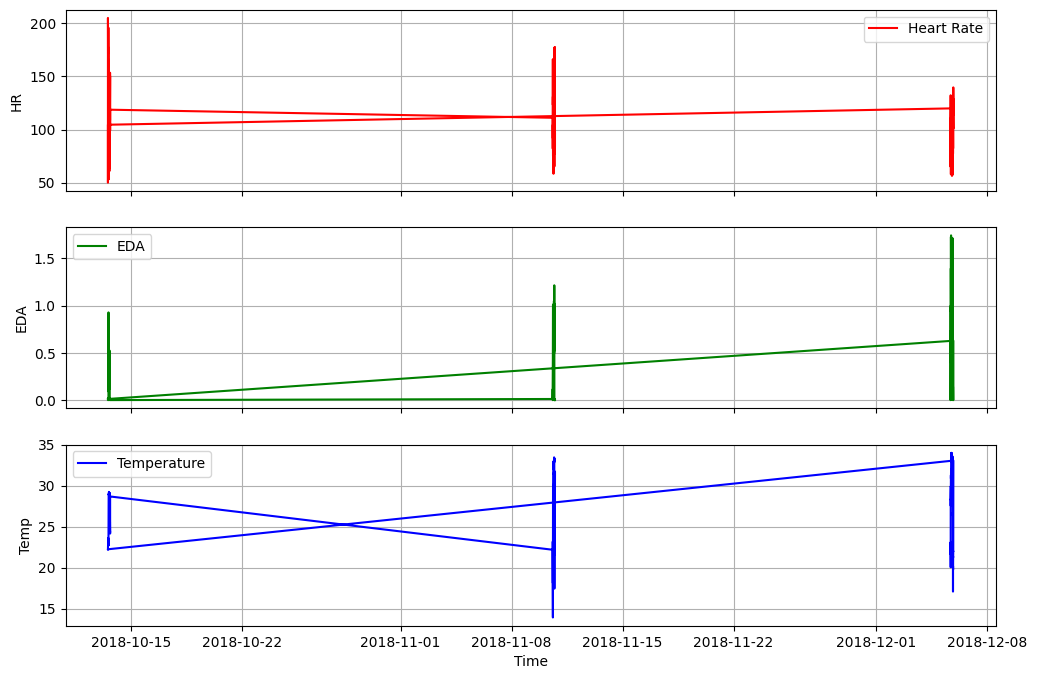

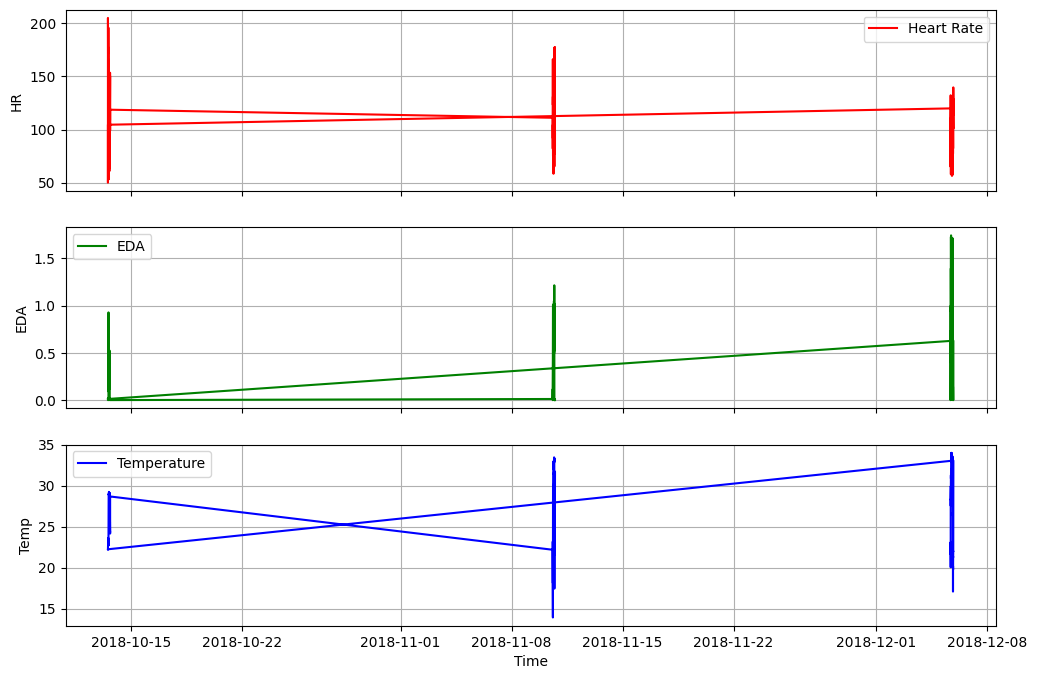

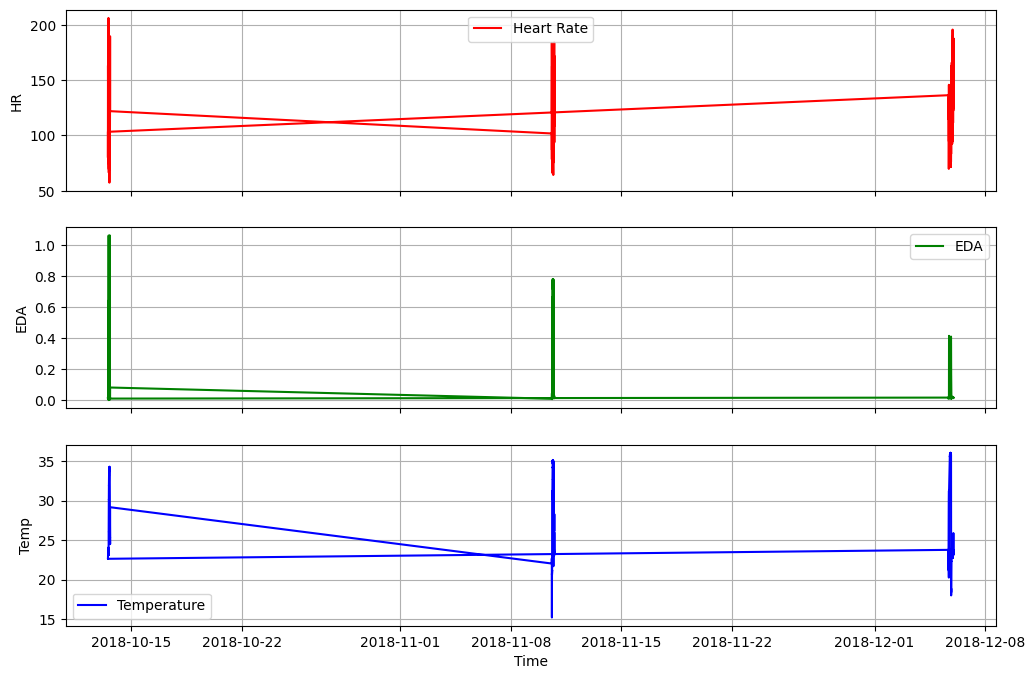

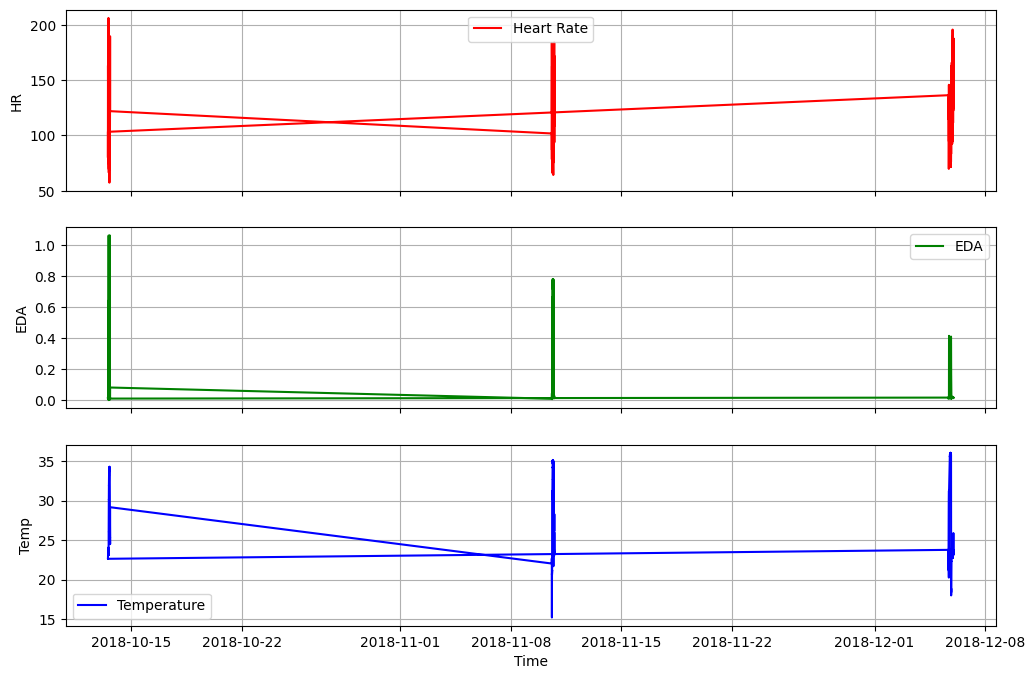

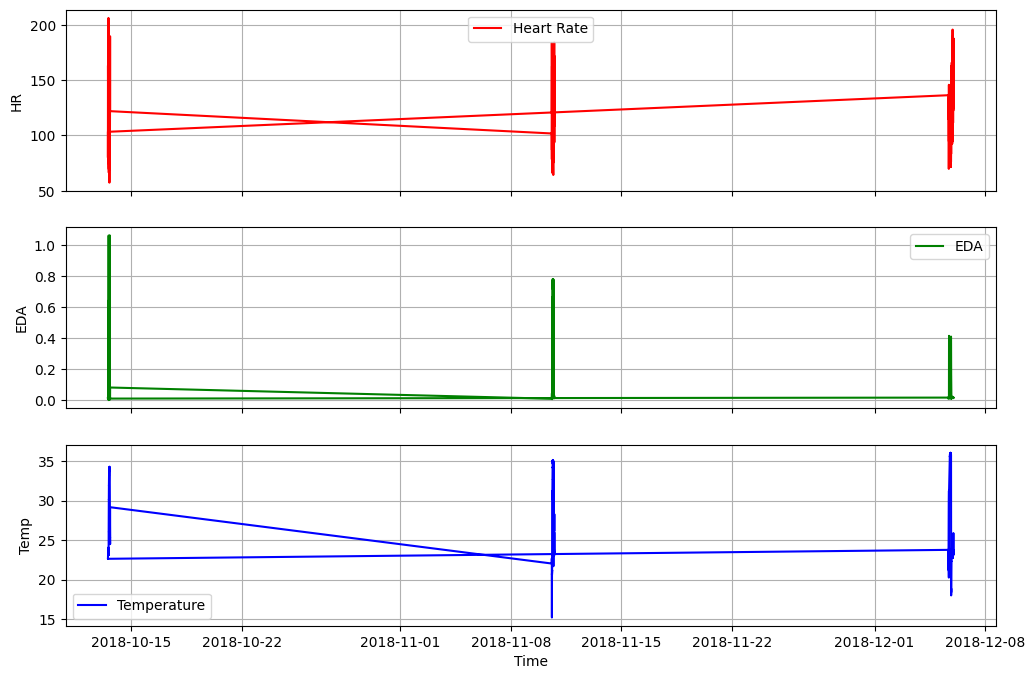

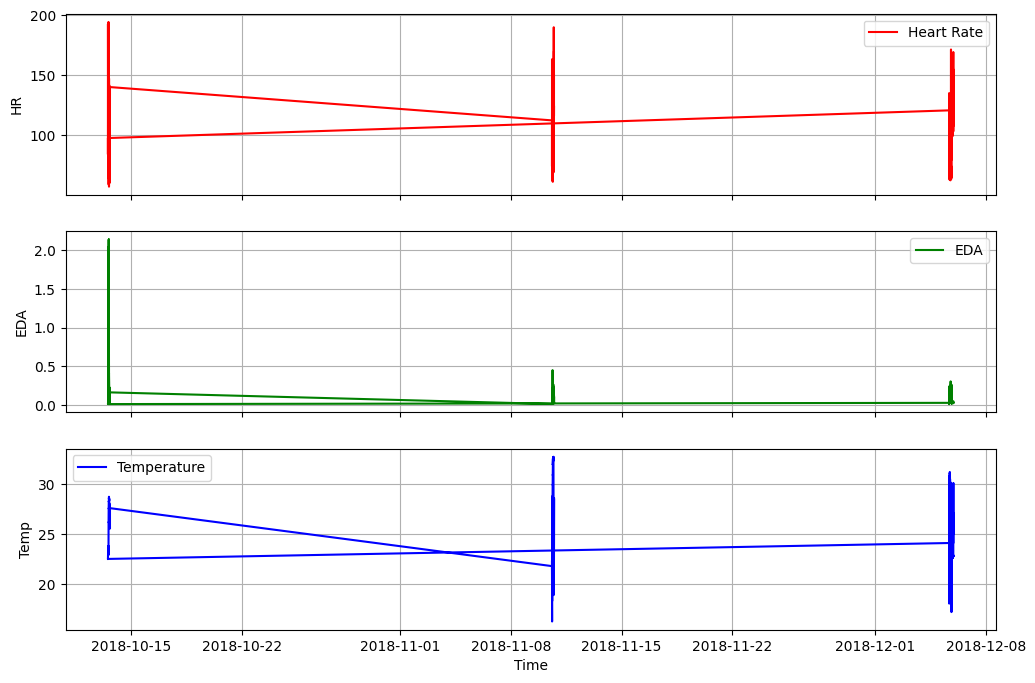

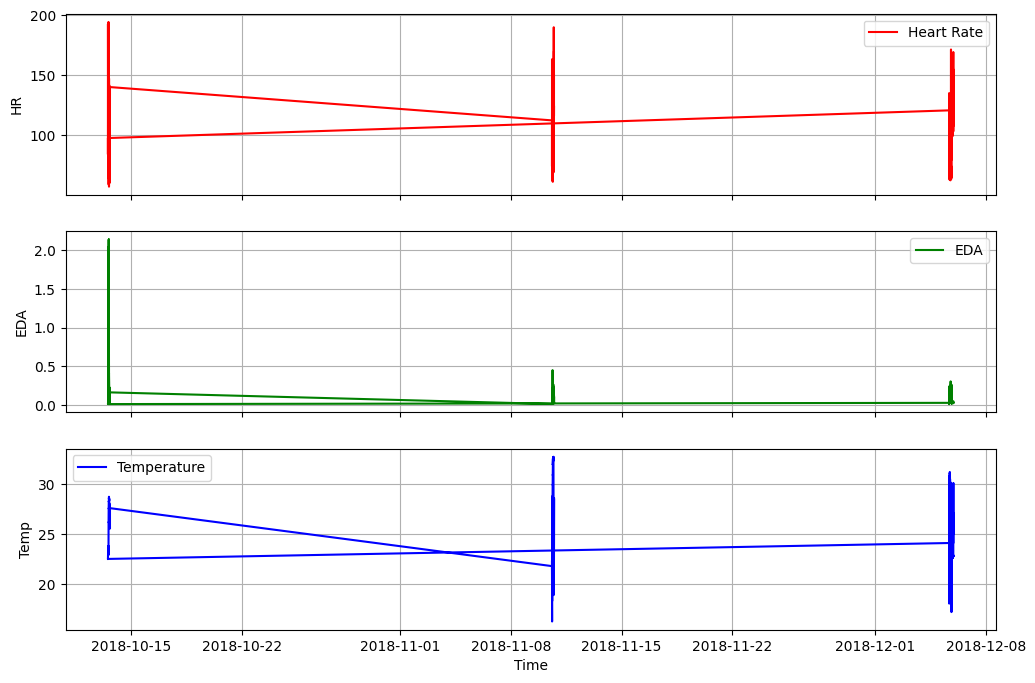

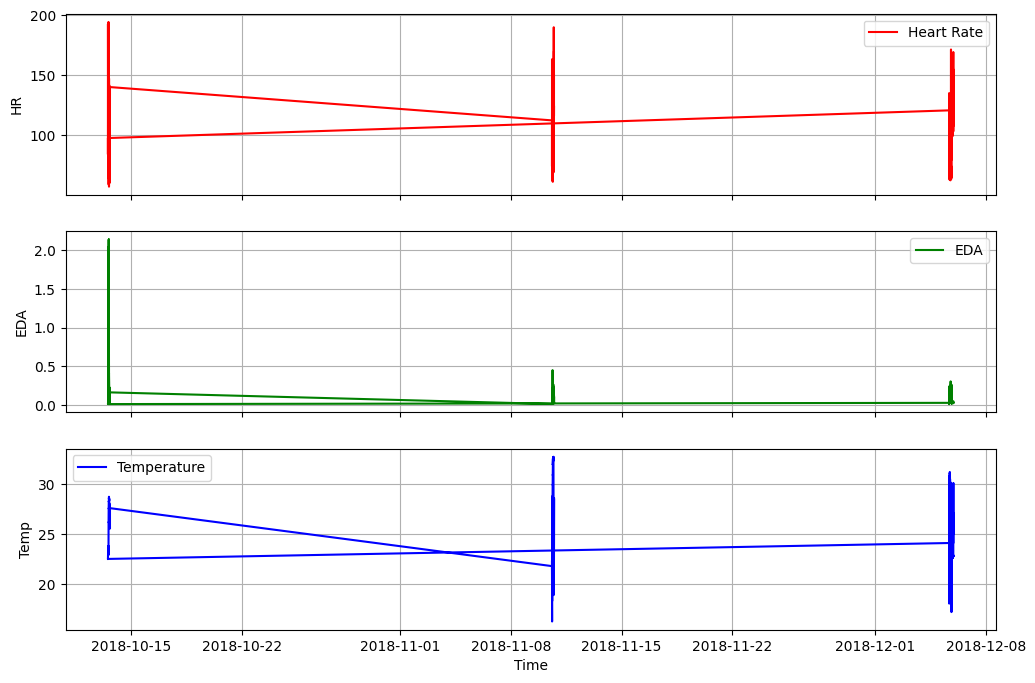

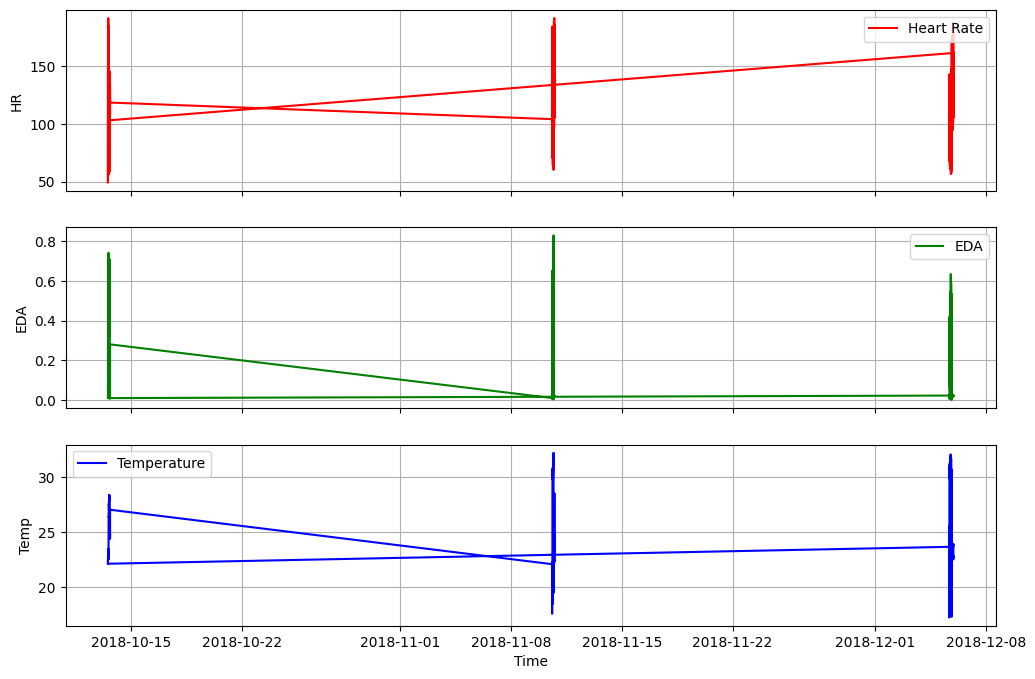

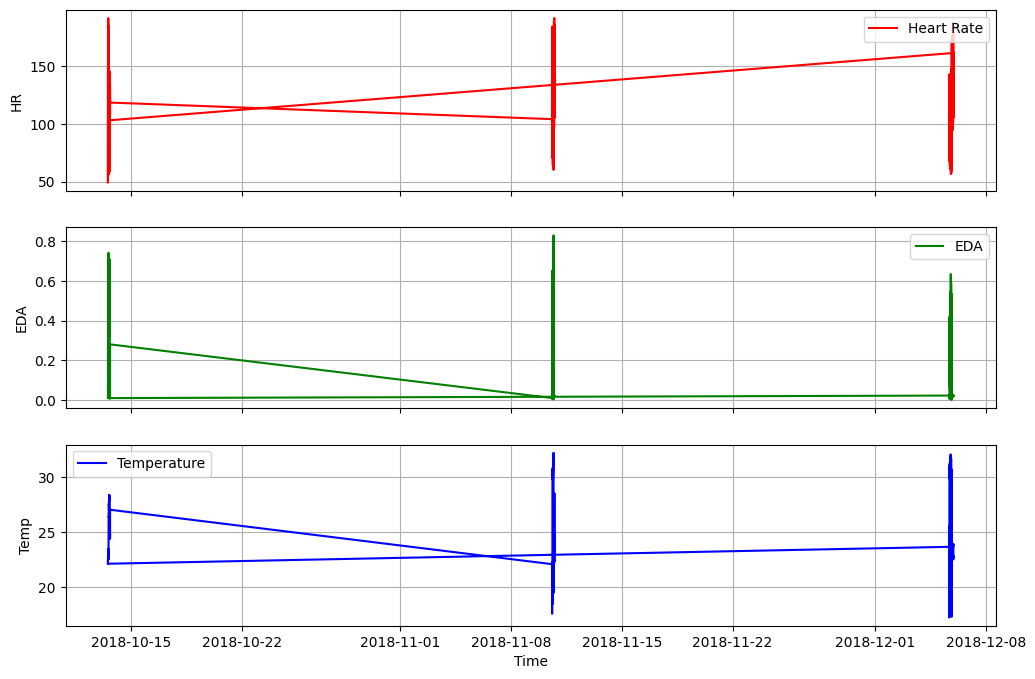

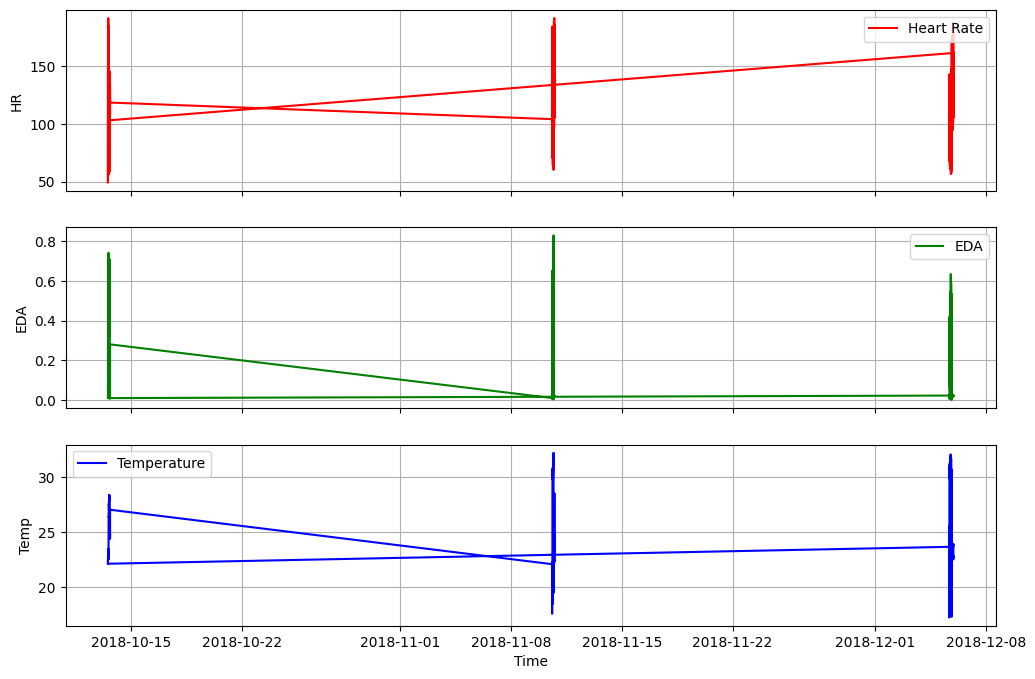

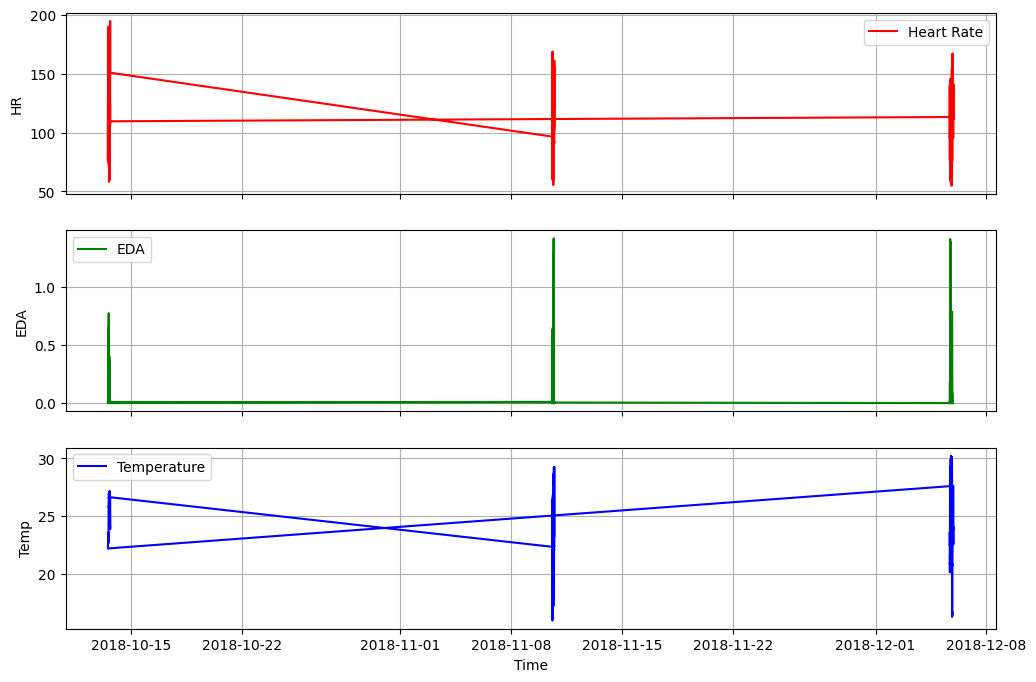

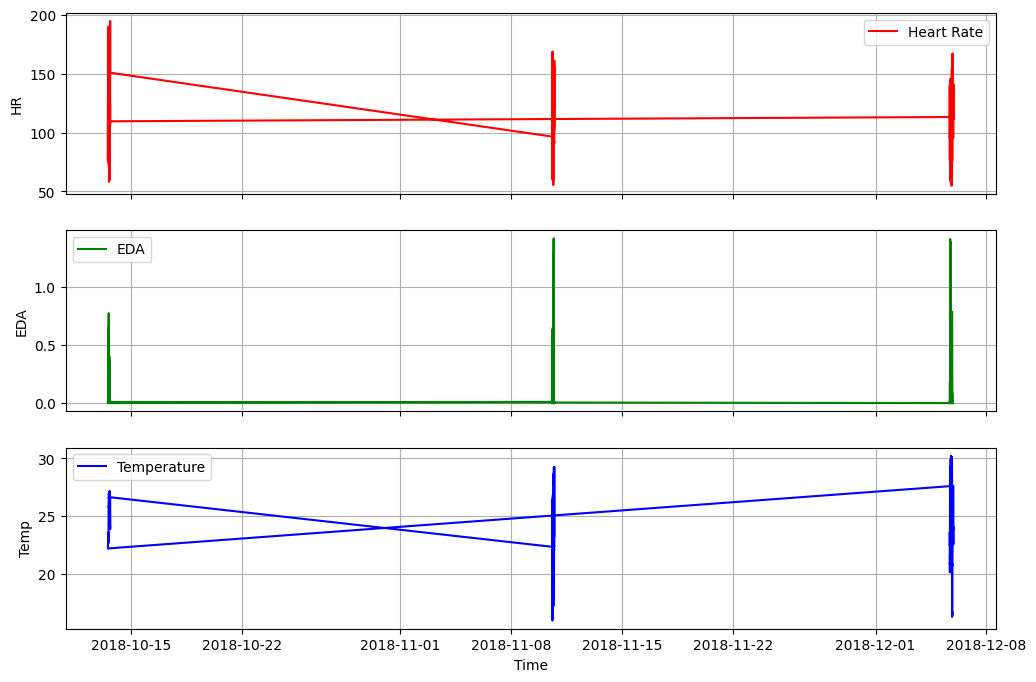

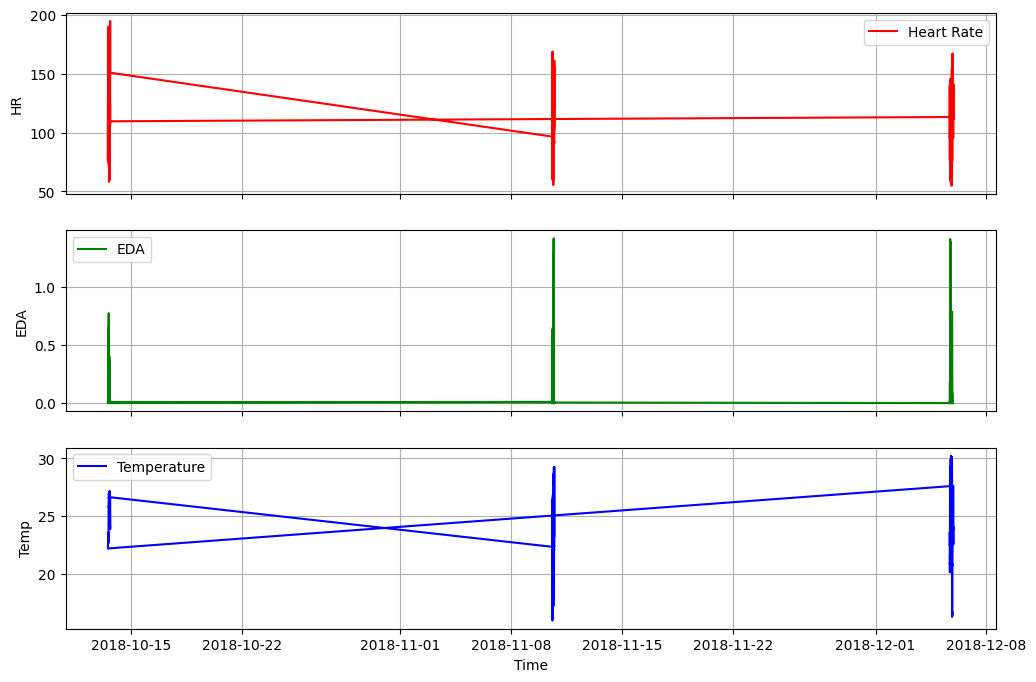

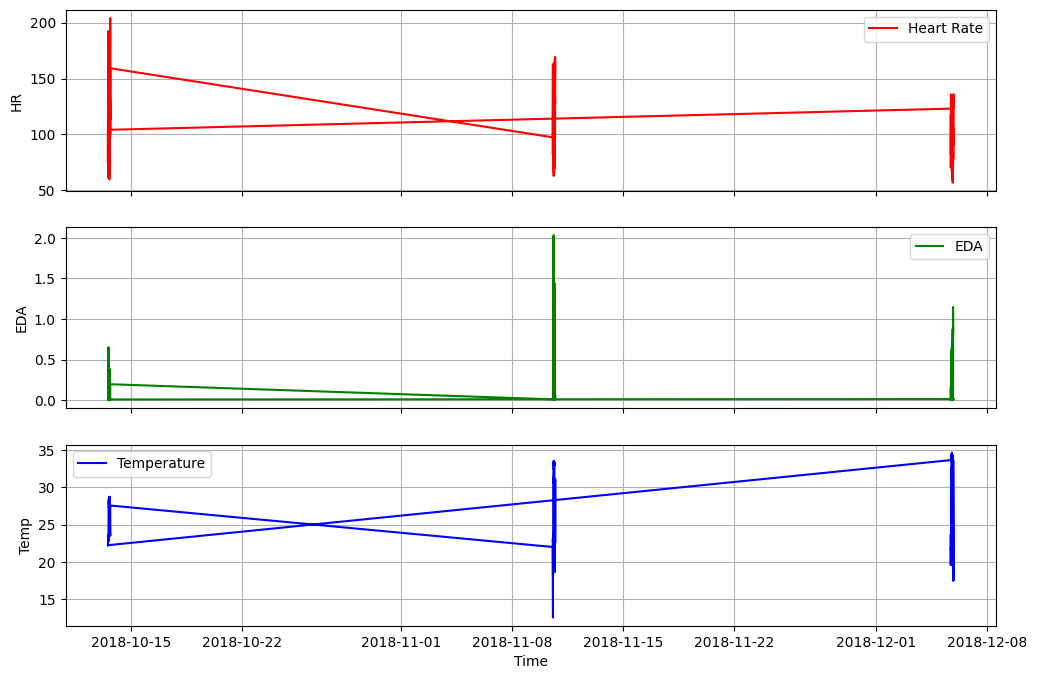

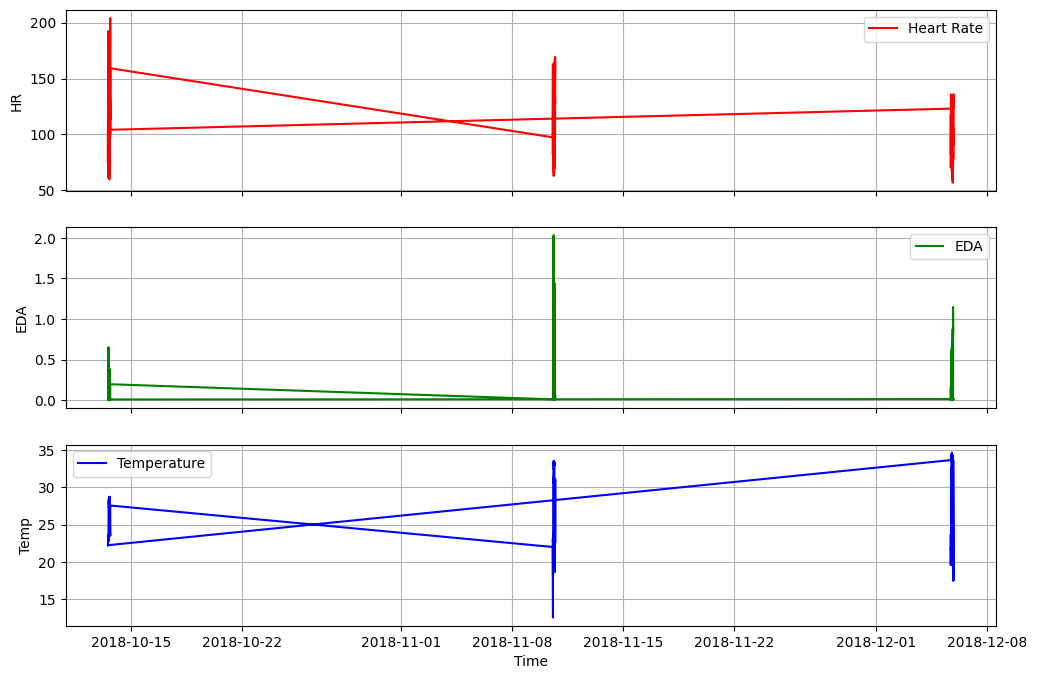

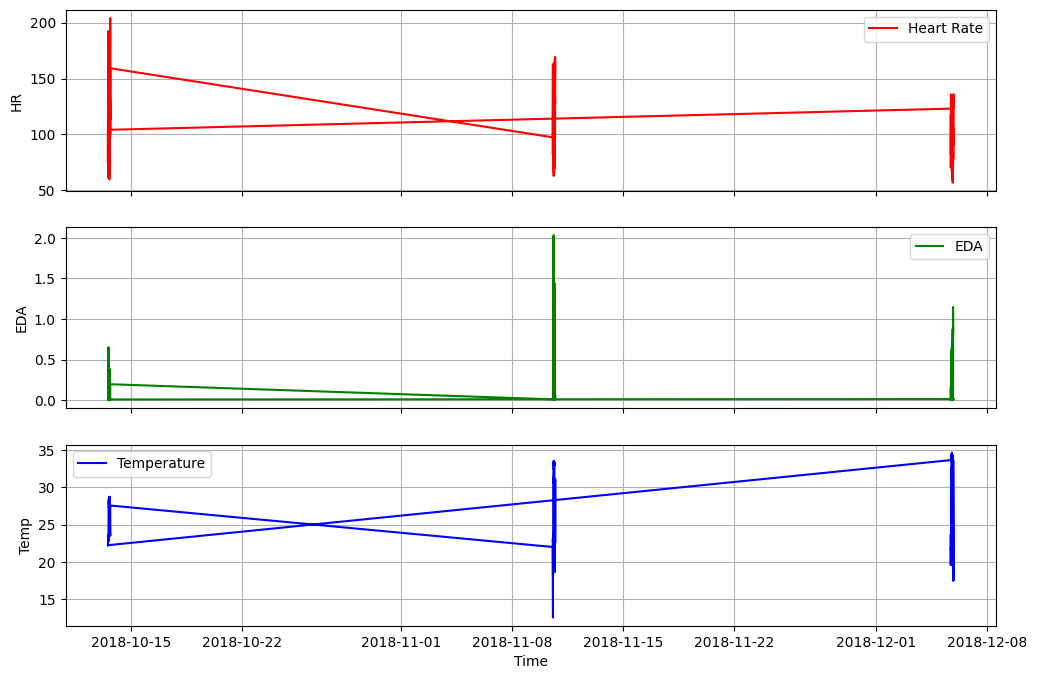

In [9]:
generate_all_plots('data/processed', 'plots')